## Лабораторная работа № 1
### Разведочный анализ данных с помощью PySpark
#### Цель и задачи работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом `Apache Spark` и возможностями, которые он предоставляет для обработки больших данных.
3. Получить навыки выполнения разведочного анализа данных использованием `pyspark`.
### Выполните разведочный анализ выбранного датасета с определением: 
* типов признаков в датасете; 
* пропущенных значений и их устранением; 
* выбросов и их устранением; 
* расчетом статистических показателей признаков (средних, квартилей и т.д.); 
* визуализацией распределения наиболее важных признаков; 
* корреляций между признаками.

## Ход работы

#### Создание сессии и загрузка датасета

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *  # col, to_date, udf, count
from pyspark.sql.types import StringType, BooleanType, DateType, IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pandas import DataFrame
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import re

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName('SOBDLab1') \
    .getOrCreate()
csv_file = 'data/itineraries.csv'
data = spark.read.csv(csv_file, header=True)
data = data.drop('legId', 'searchDate','flightDate','segmentsDepartureTimeEpochSeconds',
                 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds',
                 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode',
                 'segmentsDepartureAirportCode', 'segmentsAirlineName',
                 'segmentsAirlineCode', 'segmentsEquipmentDescription',
                 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode')


#### Определение типов признаков

In [14]:
data.printSchema()
data.first()

for column in data.columns:
    print(f'Count of distinct rows in {column}: {data.select(column).distinct().count()}')

root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: string (nullable = true)
 |-- isBasicEconomy: string (nullable = true)
 |-- isRefundable: string (nullable = true)
 |-- isNonStop: string (nullable = true)
 |-- baseFare: string (nullable = true)
 |-- totalFare: string (nullable = true)
 |-- seatsRemaining: string (nullable = true)
 |-- totalTravelDistance: string (nullable = true)

Count of distinct rows in startingAirport: 16
Count of distinct rows in destinationAirport: 16
Count of distinct rows in fareBasisCode: 21062
Count of distinct rows in travelDuration: 2110
Count of distinct rows in elapsedDays: 3
Count of distinct rows in isBasicEconomy: 2
Count of distinct rows in isRefundable: 2
Count of distinct rows in isNonStop: 2
Count of distinct rows in baseFare: 35866
Count of distinct rows in totalFare: 59104
Count of disti

#### Устранение пропущенных значений и сокращение размера

In [15]:
print(data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show())
data = data.dropna()

+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|              0|                 0|            0|             0|          0|             0|           0|        0|       0|        0|             0|            6094532|
+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+

None


#### Преобразование типов

In [16]:
def travelDurationtoInt(travelDuration: str) -> int:
    periods = re.findall(r'\d{1,2}', travelDuration)
    intDuration = 0
    if len(periods) > 0:
        intDuration = int(periods[0]) * 60
    if len(periods) > 1:
        intDuration += int(periods[1])
    return intDuration


duration_cast = udf(lambda x: travelDurationtoInt(x), IntegerType())
data = data.withColumn('travelDuration', duration_cast('travelDuration'))

data = data.withColumn('elapsedDays', data.elapsedDays.cast(IntegerType()))
data = data.withColumn('isBasicEconomy', data.isBasicEconomy.cast(BooleanType()))
data = data.withColumn('isRefundable', data.isRefundable.cast(BooleanType()))
data = data.withColumn('isNonStop', data.isNonStop.cast(BooleanType()))
data = data.withColumn('baseFare', data.baseFare.cast(DoubleType()))
data = data.withColumn('totalFare', data.totalFare.cast(DoubleType()))
data = data.withColumn('seatsRemaining', data.seatsRemaining.cast(IntegerType()))
data = data.withColumn('totalTravelDistance', data.totalTravelDistance.cast(IntegerType()))

data.printSchema()
data.show()


root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: integer (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)

+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+---------------+------------------+-------------+--------------+-----------+--------------+------------+--

#### Кодирование категориальных признаков

In [17]:
indexer = StringIndexer(inputCols=["startingAirport", "destinationAirport"],
                        outputCols=["startingAirport_indexed", "destinationAirport_indexed"],
                        stringOrderType='alphabetAsc')
indexerModel = indexer.fit(data)
data = indexerModel.transform(data)

indexer = StringIndexer(inputCols=["fareBasisCode"],
                        outputCols=["fareBasisCode_indexed"],
                        stringOrderType='alphabetAsc')
indexerModel = indexer.fit(data)
data = indexerModel.transform(data)

data = data.withColumn('startingAirport', data.startingAirport_indexed.cast(IntegerType()))
data = data.withColumn('destinationAirport', data.destinationAirport_indexed.cast(IntegerType()))
data = data.withColumn('fareBasisCode', data.fareBasisCode_indexed.cast(IntegerType()))

data = data.drop('startingAirport_indexed', 'destinationAirport_indexed', 'fareBasisCode_indexed')
data.show()


+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|              0|                 1|         4798|           149|          0|         false|       false|     true|  217.67|    248.6|             9|                947|
|              0|                 1|         4798|           150|          0|         false|       false|     true|  217.67|    248.6|             4|                947|
|              0|                 1|         4798|           150|          0|         false|       false|     true|  217.67|    248.6|             9| 

In [18]:
data.write.mode("overwrite") \
    .parquet("C:/Users/Kir/SOBDLab1/data/proceed.parquet")


#### Определение выбросов

In [19]:
data1 = data.sample(0.05, seed=42)


In [ ]:
columns = ['travelDuration', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
stats = {}
for column in columns:
    q1, q2, q3 = data1.approxQuantile(column, [0.25, 0.5, 0.75], 0)
    min_value = data.agg(min(column)).collect()[0][0]
    max_value = data.agg(max(column)).collect()[0][0]
    avg_value = data.agg(mean(column)).collect()[0][0]
    print(
        f'{column}: firstquartile = {q1} median = {q2} lastquartile = {q3}, min_value = {min_value}, max_value = {max_value}')
    IQR = q3 - q1
    lower_bound = q1 - (1.5 * IQR)
    upper_bound = q3 + (1.5 * IQR)
    stats[column] = {'mean': avg_value, 'med': q2, 'q1': q1, 'q3': q3, 'whislo': lower_bound, 'whishi': upper_bound}
    data_outliers = data.filter((data[column] < lower_bound) | (data[column] > upper_bound))
    outliers_count = data_outliers.count()
    print(f'Count of outliners in {column} = {data_outliers.count()}')
    if outliers_count > 0:
        data_outliers.select(column).show()


travelDuration: firstquartile = 255.0 median = 399.0 lastquartile = 553.0, min_value = 60, max_value = 3540
Count of outliners in travelDuration = 910952
+--------------+
|travelDuration|
+--------------+
|          1049|
|          1055|
|          1041|
|          1041|
|          1139|
|          1060|
|          1029|
|          1010|
|          1020|
|          1060|
|          1119|
|          1179|
|          1051|
|          1048|
|          1096|
|          1324|
|          1128|
|          1361|
|          1059|
|          1128|
+--------------+
only showing top 20 rows

baseFare: firstquartile = 171.16 median = 273.49 lastquartile = 407.44, min_value = 8.72, max_value = 7662.33
Count of outliners in baseFare = 1074185
+--------+
|baseFare|
+--------+
| 1488.37|
|  775.82|
|  800.93|
|  815.81|
|  848.38|
|  965.58|
|  984.19|
|  771.16|
|  775.81|
|  909.76|
| 1192.57|
|  773.02|
|  816.74|
|   840.0|
|  844.65|
|   849.3|
|   849.3|
|  890.24|
| 1171.17|
|  826.05|
+-------

#### Устранение выбросов

In [ ]:
for column in columns:
    data = data.filter((data[column] > stats[column]['whislo']) & (data[column] < stats[column]['whishi']))


In [ ]:
data1.write.mode("overwrite") \
    .parquet("C:/Users/Kir/SOBDLab1/data/cleared.parquet")


#### Визуализация распределения наиболее важных признаков

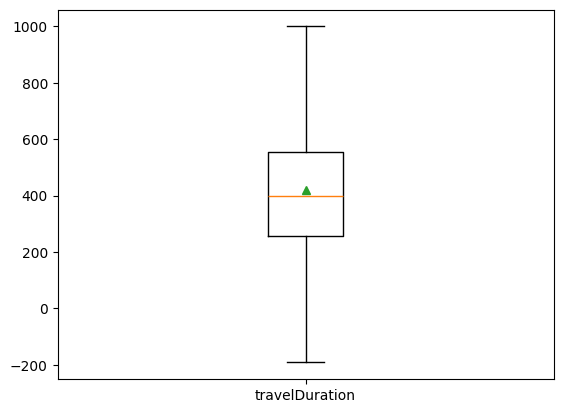

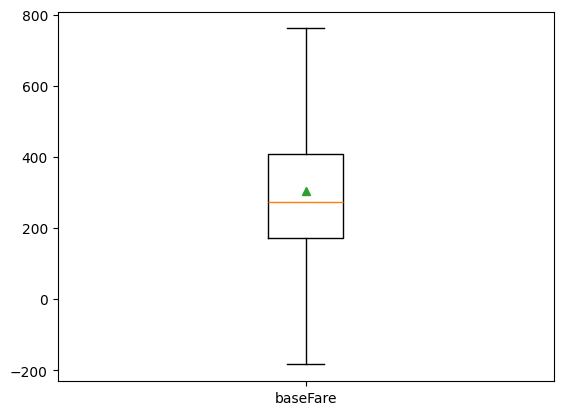

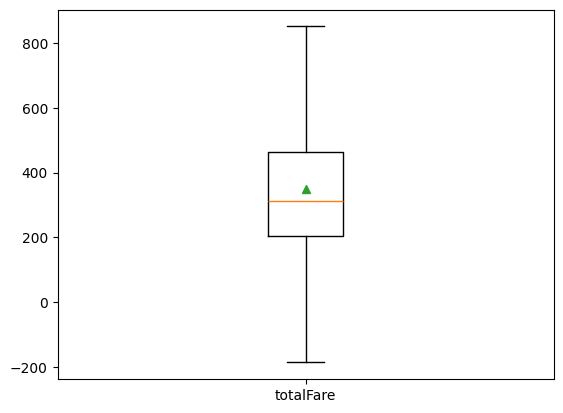

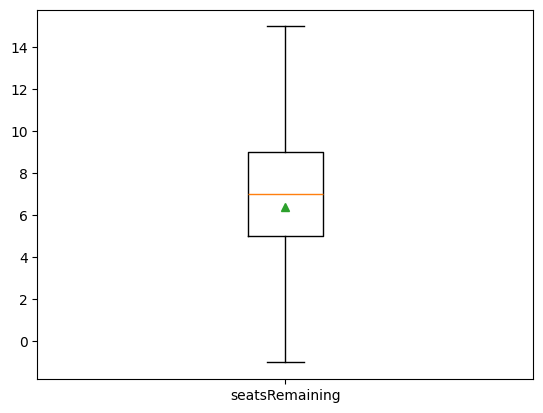

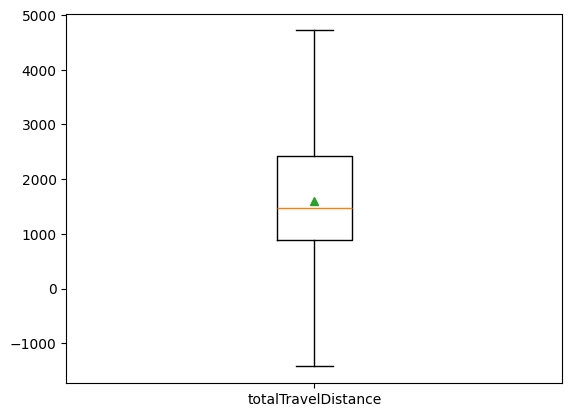

In [ ]:
import matplotlib.pyplot as plt

for column in columns:
    stats1 = [stats[column]]
    fig, ax = plt.subplots()
    ax.bxp(stats1, showfliers=False, showmeans=True)
    plt.xticks([1], [column])
    plt.show()



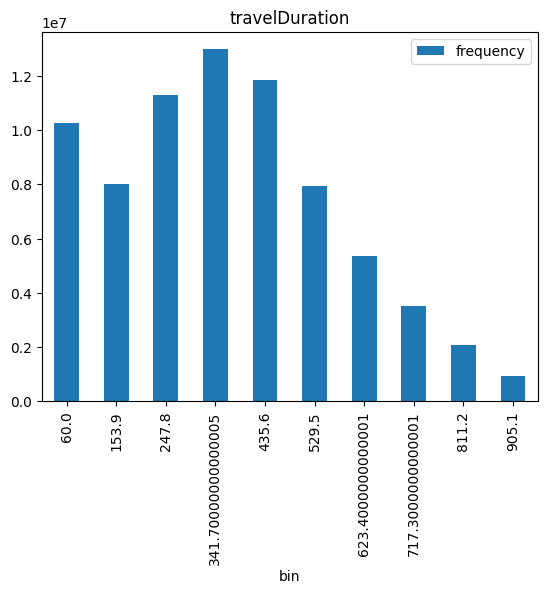

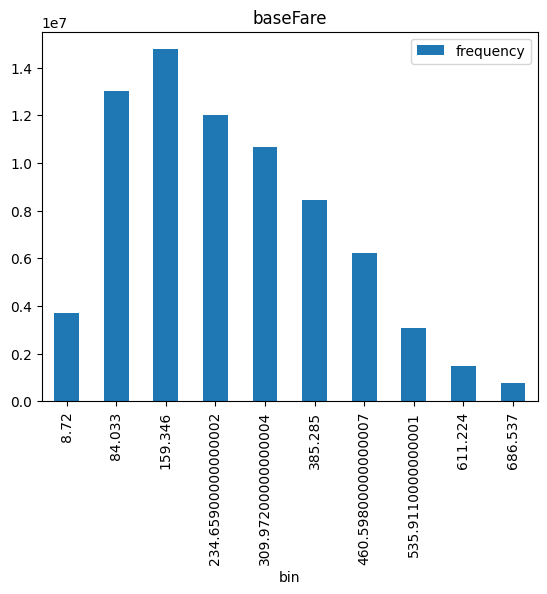

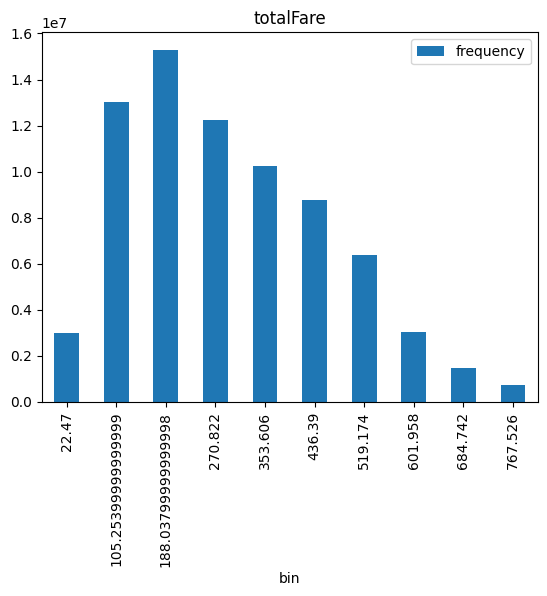

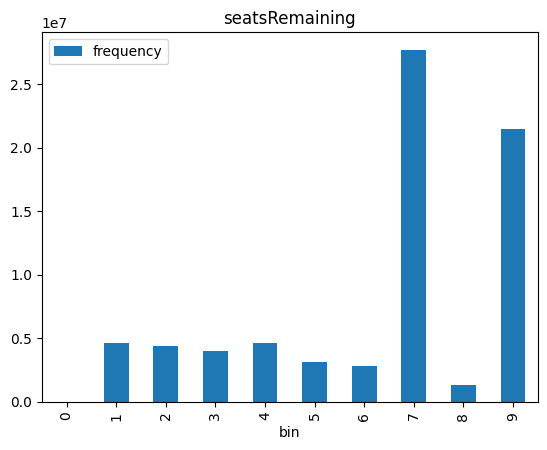

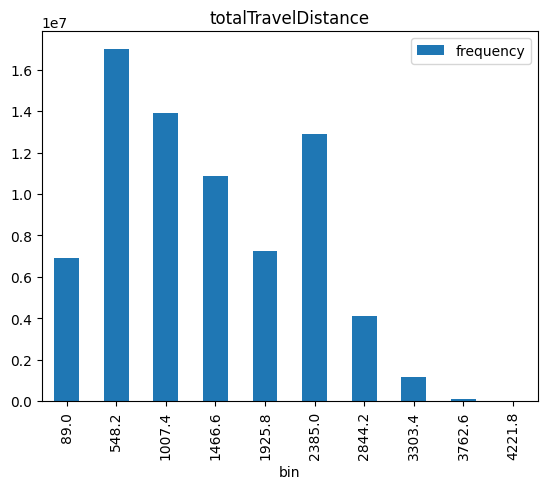

In [ ]:
for column in columns:
    DataFrame(list(zip(*data.select(column).rdd.flatMap(lambda x: x).histogram(10))), 
        columns=['bin', 'frequency']
    ).set_index(
        'bin'
    ).plot(kind='bar',title=column)

#### Корреляции между признаками

In [ ]:
data1 = data
data1 = data1.drop('searchDate', 'flightDate')

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data1.columns, outputCol=vector_col)
df_vector = assembler.transform(data1).select(vector_col)

matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = DataFrame(data=corr_matrix, columns=data1.columns, index=data1.columns)
corr_matrix_df.style.background_gradient(cmap='coolwarm')


,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance
startingAirport,1.000000,-0.082625,-0.028961,0.146004,0.139119,-0.024312,0.001475,-0.060778,0.134987,0.136755,-0.008265,0.207697
destinationAirport,-0.082625,1.000000,-0.010377,0.163782,-0.007681,-0.011056,-0.003394,-0.061530,0.109920,0.111069,-0.001219,0.198106
fareBasisCode,-0.028961,-0.010377,1.000000,-0.049005,0.018768,0.153219,-0.002477,0.063275,-0.270416,-0.268521,0.034361,-0.068292
travelDuration,0.146004,0.163782,-0.049005,1.000000,0.346838,-0.061324,-0.002656,-0.691632,0.474082,0.496002,-0.081537,0.694803
elapsedDays,0.139119,-0.007681,0.018768,0.346838,1.000000,-0.010183,-0.001420,-0.158838,0.142615,0.149371,0.003688,0.275166
isBasicEconomy,-0.024312,-0.011056,0.153219,-0.061324,-0.010183,1.000000,-0.001533,0.018963,-0.414349,-0.410054,0.330654,-0.089768
isRefundable,0.001475,-0.003394,-0.002477,-0.002656,-0.001420,-0.001533,1.000000,-0.002226,0.000978,0.000685,0.004999,-0.002745
isNonStop,-0.060778,-0.061530,0.063275,-0.691632,-0.158838,0.018963,-0.002226,1.000000,-0.310562,-0.335474,0.086529,-0.381449
baseFare,0.134987,0.109920,-0.270416,0.474082,0.142615,-0.414349,0.000978,-0.310562,1.000000,0.999535,-0.100261,0.499453
totalFare,0.136755,0.111069,-0.268521,0.496002,0.149371,-0.410054,0.000685,-0.335474,0.999535,1.000000,-0.101813,0.505908
